In [1]:
! nvidia-smi

Thu Mar  2 04:37:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-02 04:37:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-02 04:37:09 (48.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import (create_tensorboard_callback,
                             plot_loss_curves,
                             unzip_data,
                             compare_historys,
                             walk_through_dir)

In [4]:
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-03-02 04:37:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 172.217.193.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   181MB/s    in 9.1s    

2023-03-02 04:37:29 (171 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data("101_food_classes_10_percent.zip")

In [6]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [7]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baklava'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/edamame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/panna_cotta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food

In [46]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from tqdm.notebook import tqdm
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline

In [9]:
IMG_SIZE = (224, 224)

In [10]:
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               batch_size=32,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                              batch_size=32,
                                                                              label_mode="categorical",
                                                                              image_size=IMG_SIZE,
                                                                              shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [11]:
checkpoints_path = "checkpoints/"
checkpointer = tf.keras.callbacks.ModelCheckpoint(checkpoints_path,
                                                 save_best_only=True,
                                                 monitor="val_accuracy",
                                                 save_weights_only=True)

In [12]:
data_augmentation_block = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
#     tf.keras.layers.experimental.preprocessing.Rescaling(1./255), # for models like resnet
], name="data_augmentation")

In [13]:
base = tf.keras.applications.EfficientNetB0(include_top=False)
base.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [14]:
inputs = tf.keras.layers.Input(shape=(224,224,3), name="inputs")
x = data_augmentation_block(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(101, activation="softmax", name="outputs")(x)
model = tf.keras.models.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

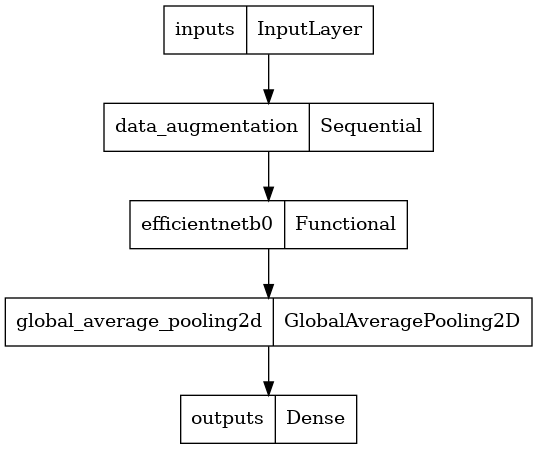

In [15]:
tf.keras.utils.plot_model(model)

In [16]:
history = model.fit(train_data_all_10_percent, epochs=5, validation_data=test_data_all_10_percent)

Epoch 1/5
237/237 [==============================] - 174s 663ms/step - loss: 3.3895 - accuracy: 0.2673 - val_loss: 2.3312 - val_accuracy: 0.4753
Epoch 2/5
237/237 [==============================] - 143s 599ms/step - loss: 2.2030 - accuracy: 0.4977 - val_loss: 1.9008 - val_accuracy: 0.5309
Epoch 3/5
237/237 [==============================] - 135s 569ms/step - loss: 1.8268 - accuracy: 0.5649 - val_loss: 1.7339 - val_accuracy: 0.5539
Epoch 4/5
237/237 [==============================] - 134s 564ms/step - loss: 1.6002 - accuracy: 0.6180 - val_loss: 1.6452 - val_accuracy: 0.5695
Epoch 5/5
237/237 [==============================] - 143s 603ms/step - loss: 1.4560 - accuracy: 0.6448 - val_loss: 1.6034 - val_accuracy: 0.5752


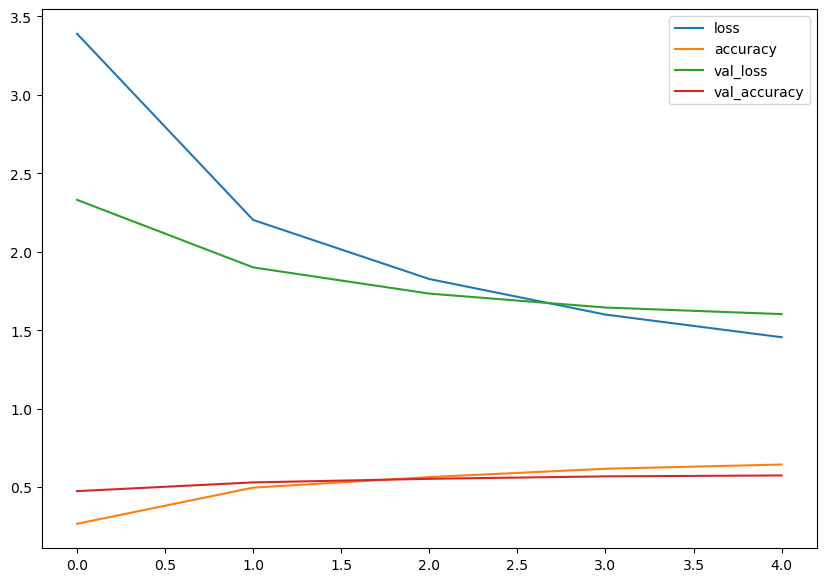

In [17]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.show()

# Fine tuning EfficientNetB0 architecture
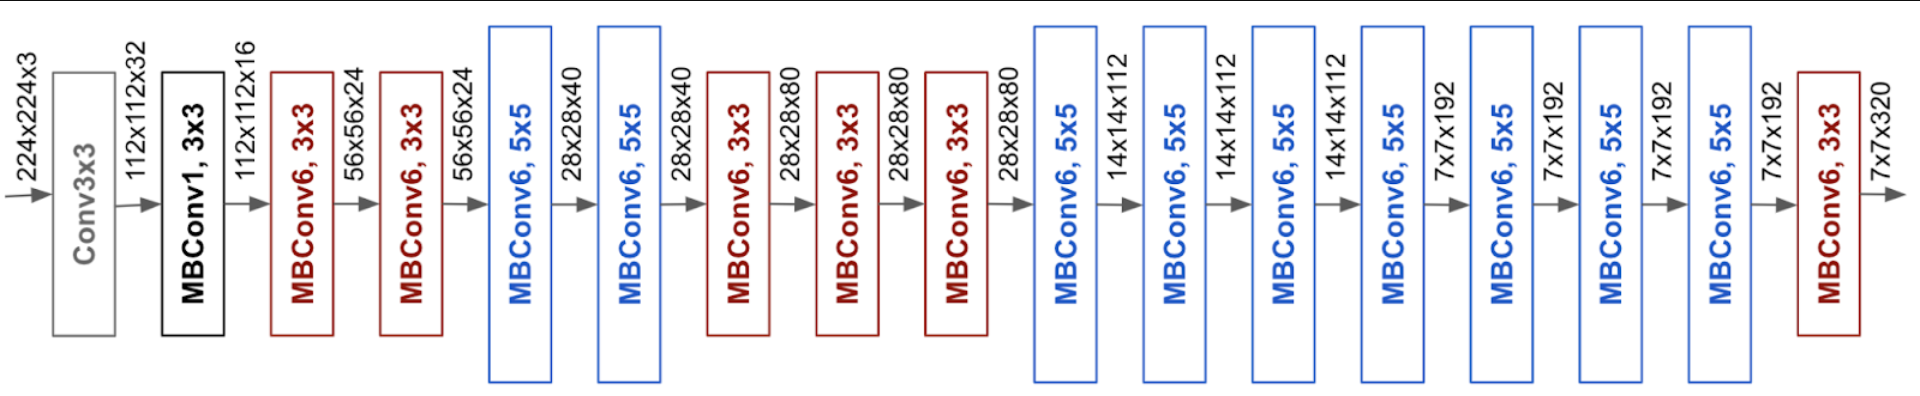

In [18]:
# unfreeze all the layers of base
base.trainable = True
# freeze all layers except top/last 5
for layer in base.layers[:-5]:
    layer.trainable = False

In [19]:
# recompile the model (lower the learning rate, it's best practice to do so while fine tuning)
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics=["accuracy"])

In [20]:
# fine tuning for 5 more epochs
history_fine_tuning = model.fit(train_data_all_10_percent, epochs=10, validation_data=test_data_all_10_percent, initial_epoch=history.epoch[-1])

Epoch 5/10
237/237 [==============================] - 150s 580ms/step - loss: 1.2046 - accuracy: 0.6834 - val_loss: 1.5352 - val_accuracy: 0.5860
Epoch 6/10
237/237 [==============================] - 131s 551ms/step - loss: 1.0831 - accuracy: 0.7143 - val_loss: 1.5246 - val_accuracy: 0.5916
Epoch 7/10
237/237 [==============================] - 131s 550ms/step - loss: 1.0163 - accuracy: 0.7286 - val_loss: 1.5200 - val_accuracy: 0.5937
Epoch 8/10
237/237 [==============================] - 131s 551ms/step - loss: 0.9429 - accuracy: 0.7496 - val_loss: 1.5087 - val_accuracy: 0.5969
Epoch 9/10
237/237 [==============================] - 151s 637ms/step - loss: 0.8867 - accuracy: 0.7620 - val_loss: 1.5021 - val_accuracy: 0.6001
Epoch 10/10
237/237 [==============================] - 127s 534ms/step - loss: 0.8350 - accuracy: 0.7780 - val_loss: 1.5125 - val_accuracy: 0.5978


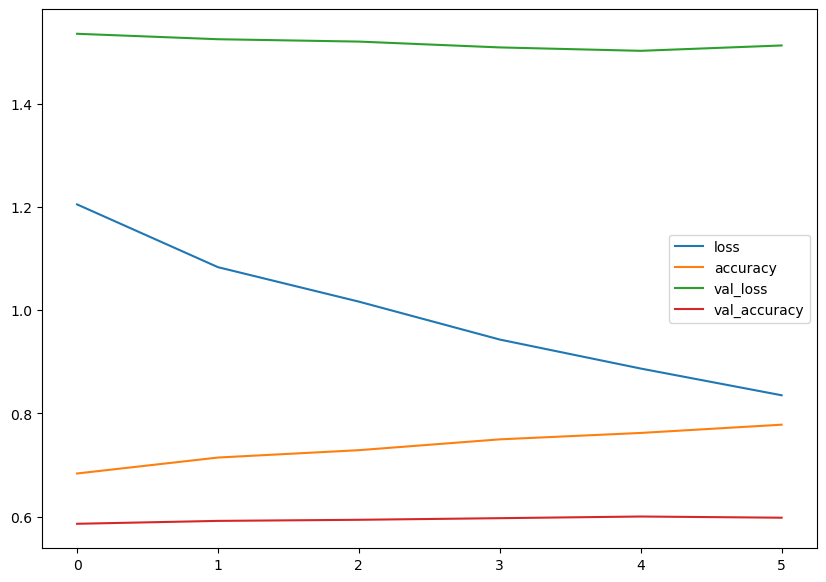

In [21]:
pd.DataFrame(history_fine_tuning.history).plot(figsize=(10,7))
plt.show()

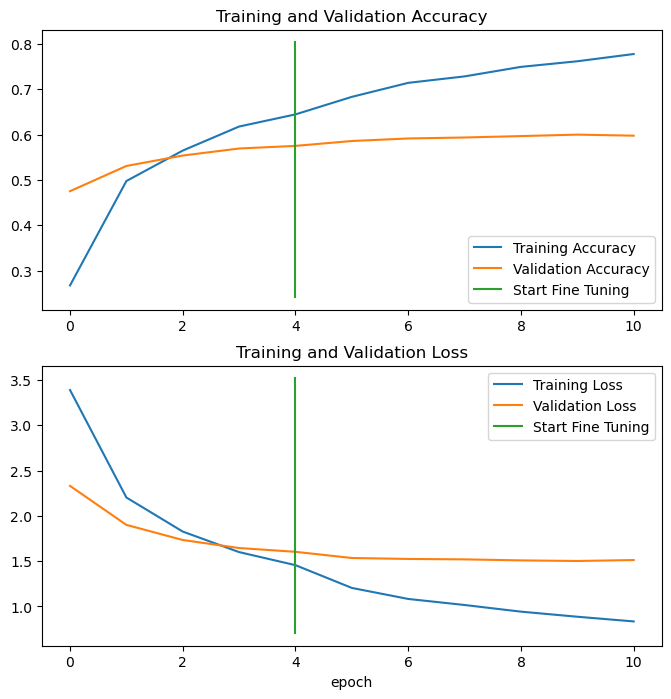

In [22]:
compare_historys(original_history=history,
                new_history=history_fine_tuning,
                initial_epochs=5)

In [24]:
model.evaluate(test_data_all_10_percent)

790/790 [==============================] - 67s 84ms/step - loss: 1.5125 - accuracy: 0.5978


[1.5125396251678467, 0.5977821946144104]

## Making predictions

In [25]:
pred_probs = model.predict(test_data_all_10_percent, verbose=1)

790/790 [==============================] - 65s 80ms/step


In [26]:
len(pred_probs)

25250

In [27]:
pred_probs.shape

(25250, 101)

In [30]:
pred_probs[0]

array([2.0150070e-01, 3.8157095e-04, 1.3464200e-01, 1.4026517e-07,
       5.5253486e-06, 2.8692752e-06, 1.4667835e-05, 1.5750184e-06,
       3.5863299e-02, 1.1423300e-04, 7.0523339e-07, 2.8835082e-05,
       3.3985396e-04, 2.0282421e-07, 1.4800779e-02, 9.4047224e-04,
       9.5870173e-06, 3.2338835e-03, 4.5922133e-03, 2.8988105e-05,
       1.0684687e-03, 1.5963655e-05, 3.7024909e-04, 1.2292249e-04,
       6.2725897e-04, 2.4556215e-03, 8.7313890e-04, 3.1393574e-05,
       1.4297822e-01, 1.3553369e-03, 9.9224817e-06, 4.1295248e-04,
       6.4878503e-04, 3.8747666e-07, 1.2174428e-02, 5.6719355e-06,
       3.2416996e-05, 2.8588609e-03, 5.1453438e-02, 4.4206641e-05,
       3.2655362e-04, 2.1726738e-03, 5.1489456e-05, 4.6883451e-06,
       8.5681655e-05, 2.5686890e-05, 2.2048247e-03, 2.2531352e-04,
       1.7033161e-06, 1.0319989e-01, 1.4551247e-04, 7.0651149e-05,
       4.9645763e-02, 1.2029408e-01, 6.1694172e-06, 5.5706236e-03,
       8.8873254e-03, 4.6624953e-04, 6.6233338e-03, 2.0359070e

In [33]:
pred_classes = pred_probs.argmax(axis=1)

In [34]:
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29, 46,  9,  0])

In [35]:
test_data_all_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [42]:
y_labels = []
for image, labels in tqdm(test_data_all_10_percent.unbatch()):
    y_labels.append(labels.numpy().argmax()) # taking argmax, as labels are one hot encoded

0it [00:00, ?it/s]

In [43]:
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [45]:
accuracy_score(y_labels, pred_classes)

0.5977821782178218

In [47]:
cm = confusion_matrix(y_labels, pred_classes)

In [50]:
plot_confusion_matrix(cm, class_names=test_data_all_10_percent.class_names, figsize=(100,100), cmap=plt.cm.Blues)
plt.show()

In [54]:
metrics = classification_report(y_labels, pred_classes, output_dict=True)

In [56]:
class_f1_scores = {}
for k, v in metrics.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[test_data_all_10_percent.class_names[int(k)]] = v["f1-score"]

In [57]:
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
33,edamame,0.974155
63,macarons,0.872247
69,oysters,0.850394
91,spaghetti_carbonara,0.845124
45,frozen_yogurt,0.839216
...,...,...
82,ravioli,0.310940
93,steak,0.278422
39,foie_gras,0.270588
77,pork_chop,0.255319


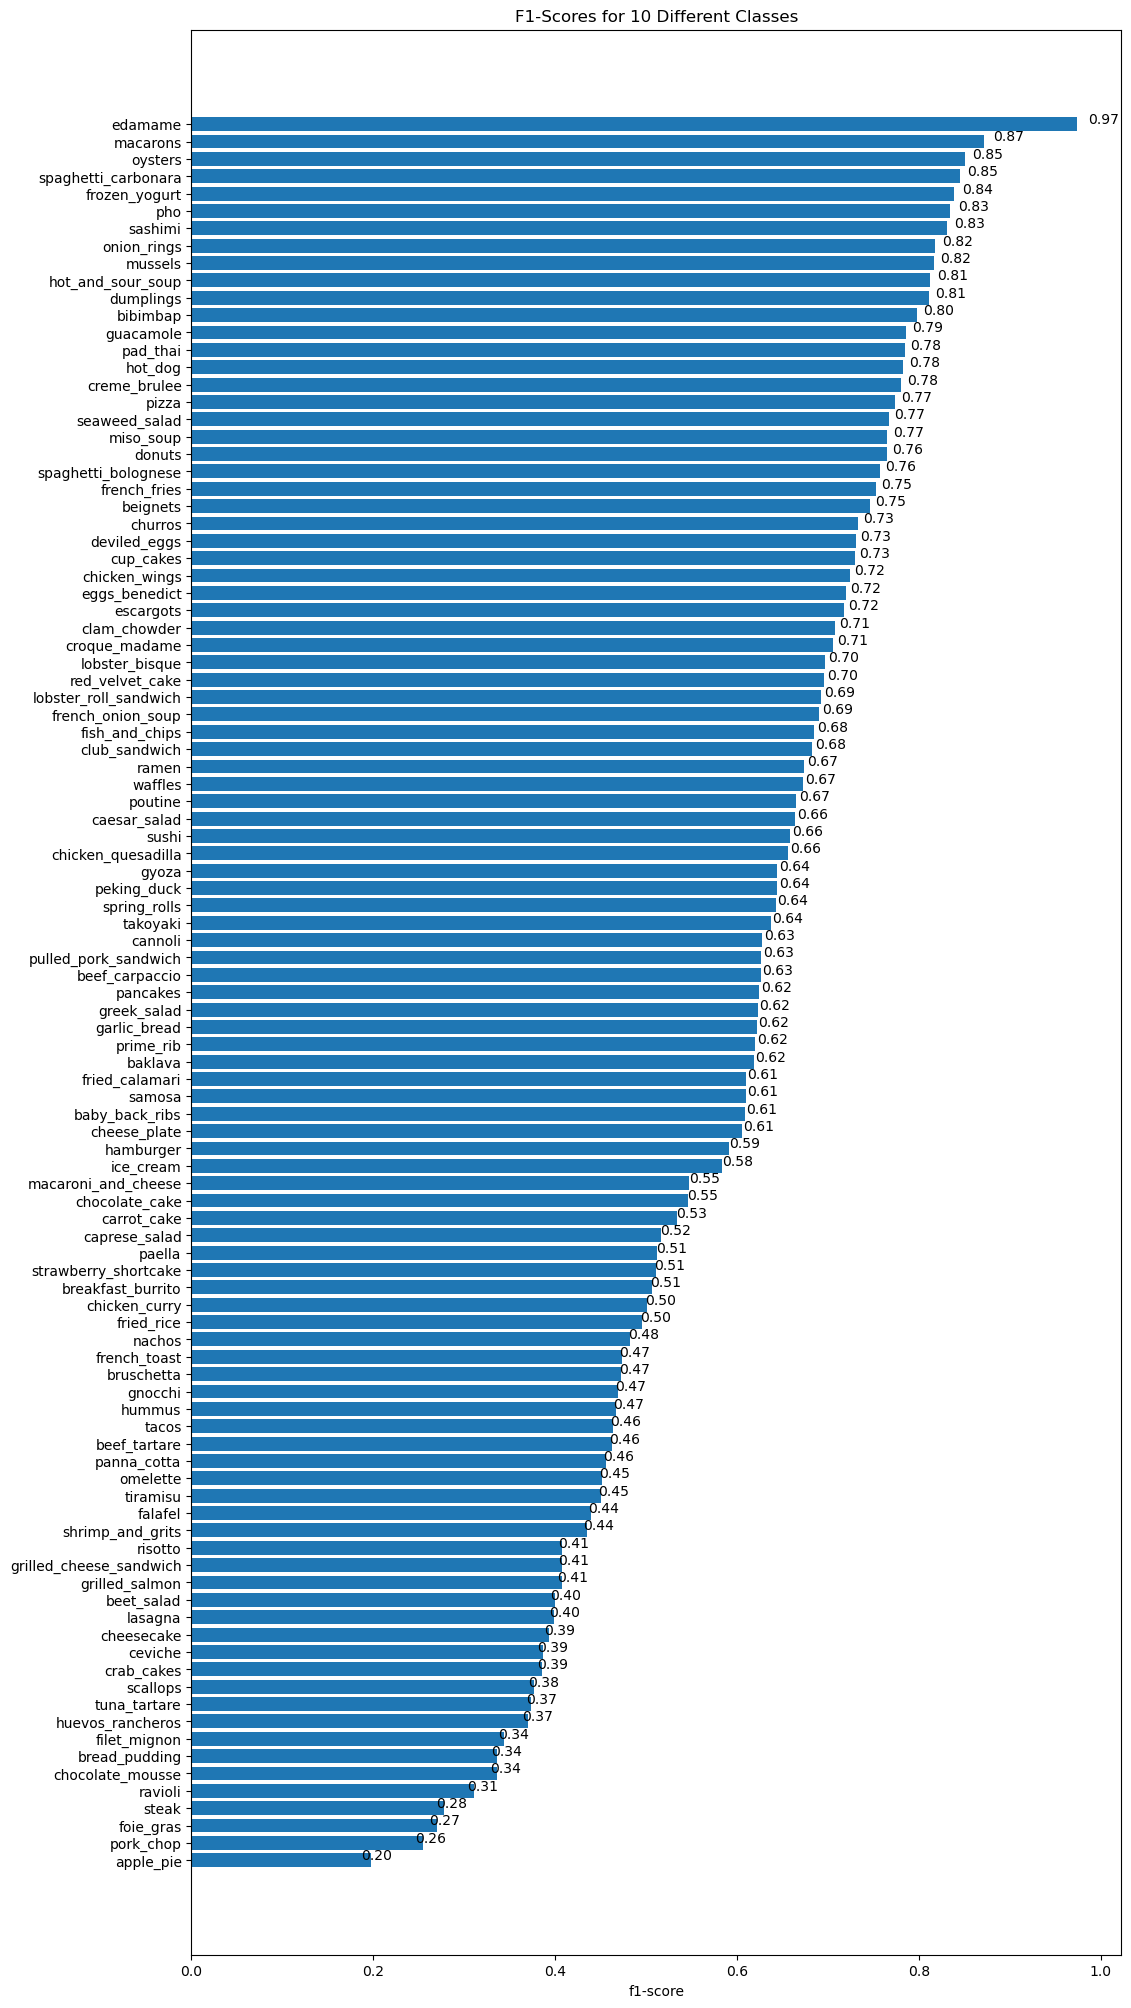

In [58]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)